In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

In [1]:
from google.colab import files
uploaded = files.upload()

Saving merge_data_final.xlsx to merge_data_final.xlsx


In [17]:
df = pd.read_excel('merge_data_final.xlsx')
df.head()

,TienSuYKhoa,ChamNoi,CungNhac,CoLap,ChoiGiaVo,HanhViLapLai,KyNangGiaoTiepSom,ChoiLuanPhien,BatChuoc,SaiViec,PhanUngTenGoi,ChiTro,ChuYLienKet,TiepXucMat,TargetBinary
0,0,1,0,1,0,0,1,1,0,1,0,0,1,1,1
1,0,1,0,1,0,1,1,0,0,1,0,1,1,1,1
2,0,1,0,0,1,0,1,0,0,0,1,1,1,1,1
3,0,0,0,0,1,1,1,0,1,0,1,1,1,1,1
4,0,1,0,0,1,0,1,0,1,0,1,1,1,1,1


# Chia dữ liệu Train - Test

In [18]:
X = df.iloc[:, 0:14]      # lấy từ cột 0 đến 13 (14 đặc trưng)
y = df.iloc[:, 14]        # lấy cột TargetBinary (vị trí 14)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True,      # Có thể bỏ vì mặc định đã là True
    stratify=y         # Rất quan trọng trong bài toán classification
)
print("Phân phối trong tập huấn luyện:")
print(y_train.value_counts(normalize=True))
print("\nPhân phối trong tập kiểm tra:")
print(y_test.value_counts(normalize=True))
print(f"Kích thước tập train: {len(X_train)} dòng")
print(f"Kích thước tập test: {len(X_test)} dòng")

Phân phối trong tập huấn luyện:
TargetBinary
1    0.721286
0    0.278714
Name: proportion, dtype: float64

Phân phối trong tập kiểm tra:
TargetBinary
1    0.719512
0    0.280488
Name: proportion, dtype: float64
Kích thước tập train: 653 dòng
Kích thước tập test: 164 dòng


In [6]:
# Không chạy lại
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10],              # Tránh None vì có thể tạo cây quá phức tạp
    'min_samples_leaf': [2, 4, 6],           # Không nên để quá nhỏ (tránh overfitting)
    'min_samples_split': [2, 5, 10],         # Kiểm soát việc phân nhánh quá mức
    'max_leaf_nodes': [None, 10, 20, 30]     # Kiểm soát số lượng node lá (giới hạn độ phức tạp)
}
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',        # hoặc 'accuracy', 'recall', tùy mục tiêu
    n_jobs=-1            # chạy song song nếu có nhiều CPU
)

grid.fit(X_train, y_train)
print("Thông số tốt nhất:", grid.best_params_)


Thông số tốt nhất: {'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=7,
    max_leaf_nodes=10,
    min_samples_leaf=4,
    min_samples_split=2,
    random_state=42
)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, max_leaf_nodes=10, min_samples_leaf=4,
                       random_state=42)

In [21]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
import pandas as pd

# 1. Dự đoán nhãn và xác suất
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # xác suất lớp 1 (nếu là binary)

# 2. Tính các độ đo
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# 3. Tạo bảng kết quả
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-score', 'ROC-AUC'],
    'Score': [precision, recall, f1, roc_auc]
})
metrics_df['Score'] = metrics_df['Score'].round(3)

# 4. Hiển thị
print("=== Evaluation Metrics (Chạy đơn) ===")
print(metrics_df)


=== Evaluation Metrics (Chạy đơn) ===
      Metric  Score
0  Precision  0.890
1     Recall  0.890
2   F1-score  0.890
3    ROC-AUC  0.868


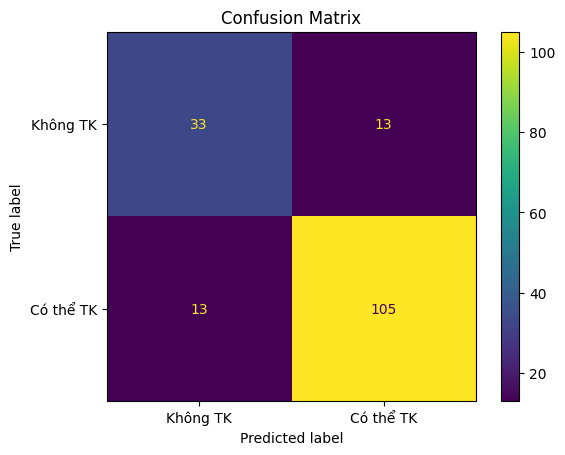

In [22]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Không TK', 'Có thể TK'])
plt.title("Confusion Matrix")
plt.show()

# CROSS VALIDATION

In [23]:
# 2. Thiết lập Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Lưu độ đo
recall_scores = []
precision_scores = []
f1_scores = []
roc_auc_scores = []

# 4. Lặp qua từng fold
for train_index, test_index in kf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_test_fold)
    y_proba_fold = model.predict_proba(X_test_fold)[:, 1]

    recall_scores.append(recall_score(y_test_fold, y_pred_fold))
    precision_scores.append(precision_score(y_test_fold, y_pred_fold))
    f1_scores.append(f1_score(y_test_fold, y_pred_fold))
    roc_auc_scores.append(roc_auc_score(y_test_fold, y_proba_fold))

# 5. Tạo DataFrame kết quả
results_df = pd.DataFrame({
    "Metric": ["Recall", "Precision", "F1-score", "ROC-AUC"],
    "Mean": [
        np.mean(recall_scores),
        np.mean(precision_scores),
        np.mean(f1_scores),
        np.mean(roc_auc_scores)
    ],
    "Std": [
        np.std(recall_scores),
        np.std(precision_scores),
        np.std(f1_scores),
        np.std(roc_auc_scores)
    ]
})

# Làm tròn 3 chữ số
results_df["Mean"] = results_df["Mean"].round(3)
results_df["Std"] = results_df["Std"].round(3)

# Hiển thị bảng
print(results_df)


      Metric   Mean    Std
0     Recall  0.871  0.023
1  Precision  0.910  0.024
2   F1-score  0.890  0.020
3    ROC-AUC  0.841  0.038


# MÔ HÌNH CÂY

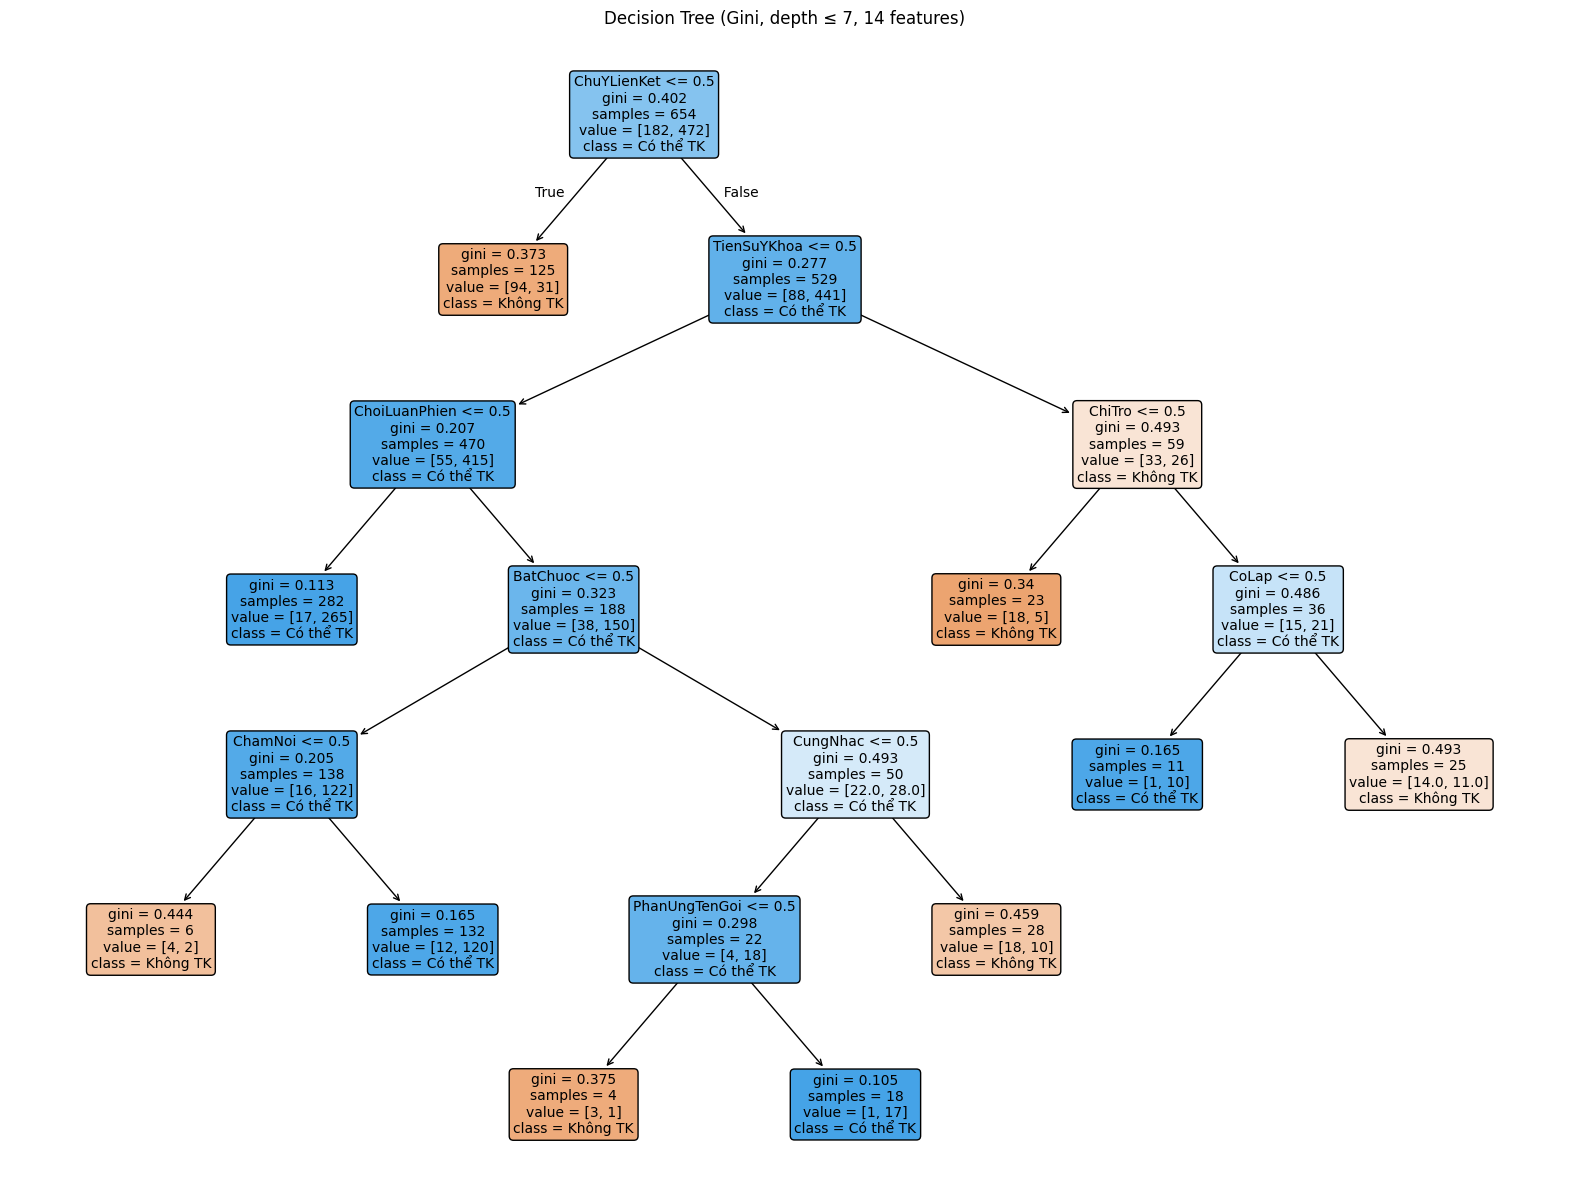

In [24]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Nếu X_train là DataFrame
plt.figure(figsize=(20, 15))  # Tùy chỉnh kích thước phù hợp
plot_tree(
    model,
    feature_names=X_train.columns,                # hoặc list 14 tên cột
    class_names=['Không TK', 'Có thể TK'],        # mapping 0 → 'Không TK', 1 → 'Có thể TK'
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree (Gini, depth ≤ 7, 14 features)")
plt.show()